# 带钢表面缺陷分类识别

### 导入相关的Python包

In [6]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.neighbors import LocalOutlierFactor
import numpy as np

### 数据预处理

#### 导入数据集

In [3]:
# 屏蔽所有警告信息
warnings.filterwarnings('ignore')
# 以 DataFrame 的形式导入标签文件
labels_pd = pd.read_csv('Faults27x7_var', header=None, prefix="0")
# 提取出标签文件的数据
labels_data = labels_pd.values
# 以 DataFrame的形式导入数据集
dataset = pd.read_table('Faults.tsv', header=None, prefix="0")
# 设置数据集的标签
columns = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
dataset.columns = columns
# 查看数据集
dataset

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1
1937,144,175,340581,340598,287,44,24,34599,112,133,...,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1
1938,145,174,386779,386794,292,40,22,37572,120,140,...,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1
1939,137,170,422497,422528,419,97,47,52715,117,140,...,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1


#### 查看数据基本信息

In [4]:
# 查看数据集大小
dataset.shape

(1941, 34)

#### 查看数据集是否有缺失值和离散值

In [91]:
# 查看数据集是否有缺失值
dataset.shape[0] - dataset.count(0)

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

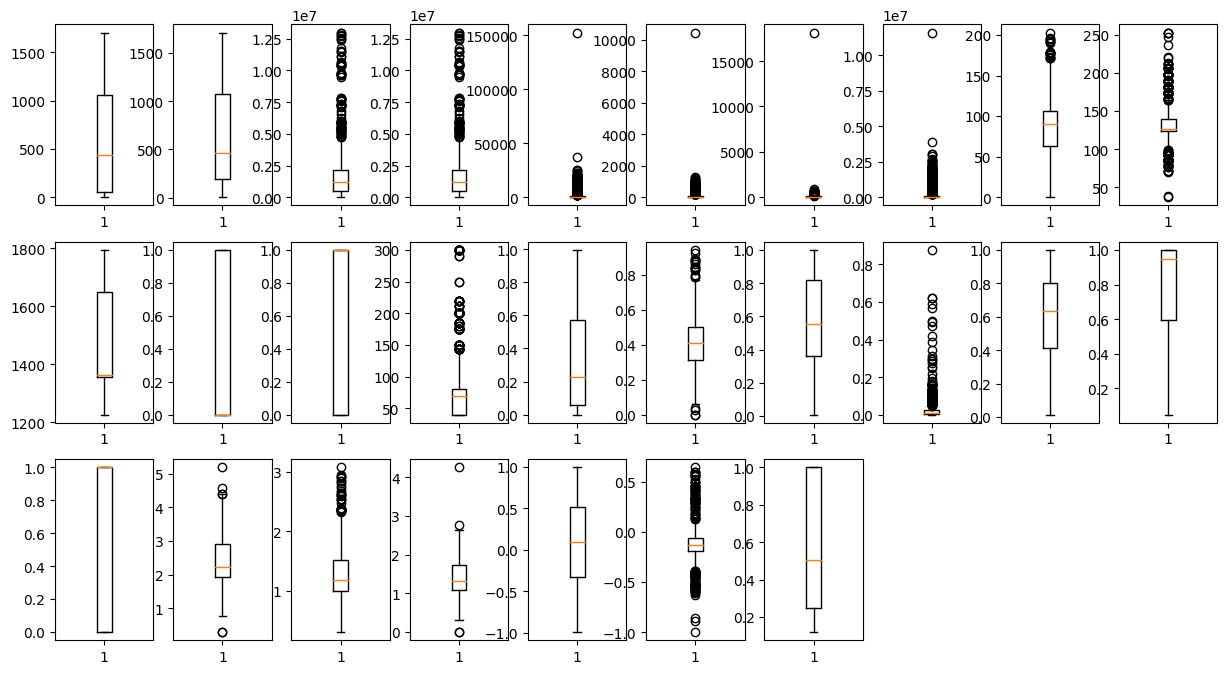

In [17]:
# 查看数据集是否有离散值
# 1.箱型图法
plt.figure(figsize=(15, 8))
for i in range(1, 28, 1):
    plt.subplot(3, 10, i)
    plt.boxplot(dataset[dataset.columns[i - 1]])

In [14]:
# 2.局部离群值因子法(LOF)
clf = LocalOutlierFactor(n_neighbors=20)  # 近邻数是超参数，20为默认值，一般取该值效果不错
dataset_LOF_copy = dataset[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']].copy()
y_pred = clf.fit_predict(np.array(dataset_LOF_copy))  # 结果中-1表离群样本，1表正常样本
LOF_arr = dataset[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']][y_pred==-1]
LOF_arr

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
4,1,0,0,0,0,0,0
6,1,0,0,0,0,0,0
9,1,0,0,0,0,0,0
12,1,0,0,0,0,0,0
14,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1749,0,0,0,0,0,0,1
1763,0,0,0,0,0,0,1
1863,0,0,0,0,0,0,1
1891,0,0,0,0,0,0,1


#### 将输入特征与输出特征分开

In [18]:
X = dataset[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']]
# 将dataset数据集转为二维数组
dataset_data = dataset.values
# 将原数据集的Y化简到1维，Pastry为1，Z_Scratch为2，以此类推直到7
Y_data = []
for i in range(len(dataset_data)):
    for j in range(27, 34, 1):
        if (dataset_data[i][j] == 1):
           Y_data.append(j - 27 + 1)
# 将Y的数据转为英文，便于分析
for i in range(len(Y_data)):
    if (Y_data[i] == 1):
        Y_data[i] = 'Pastry'
    elif (Y_data[i] == 2):
        Y_data[i] = 'Z_Scratch'
    elif (Y_data[i] == 3):
        Y_data[i] = 'K_Scratch'
    elif (Y_data[i] == 4):
        Y_data[i] = 'Stains'
    elif (Y_data[i] == 5):
        Y_data[i] = 'Dirtiness'
    elif (Y_data[i] == 6):
        Y_data[i] = 'Bumps'
    elif (Y_data[i] == 7):
        Y_data[i] = 'Other_Faults'
# 输出集
Y = pd.DataFrame(Y_data)
Y.columns = ['category']
Y

,category
0,Pastry
1,Pastry
2,Pastry
3,Pastry
4,Pastry
...,...
1936,Other_Faults
1937,Other_Faults
1938,Other_Faults
1939,Other_Faults


### 分离训练集和测试集

In [19]:
# 分层划分训练集和测试集，使训练集、测试集中各类别样本数量比例与原始数据集保持一致
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=3, stratify=Y)
# test_size:  若为小数，则为测试集样本占总样本的比例；若为整数，则为测试集样本数量
# random_state：随机数的种子，在需要重复试验的时候，指定一个固定值，则得到相同的划分结果
# stratify：划分前是否打乱原始样本顺序
y_train.value_counts()  # 训练集中各类样本数量统计

category    
Other_Faults    605
Bumps           362
K_Scratch       352
Z_Scratch       171
Pastry          142
Stains           65
Dirtiness        49
dtype: int64

In [20]:
# 测试集中各类样本数量统计
y_test.value_counts()

category    
Other_Faults    68
Bumps           40
K_Scratch       39
Z_Scratch       19
Pastry          16
Stains           7
Dirtiness        6
dtype: int64

### 使用决策树进行分类

In [119]:
dtc = DecisionTreeClassifier(criterion="gini", splitter="best")
# criterion: 指定节点不纯度的度量指标，可为gini（基尼不纯度，默认）或entropy（信息增益）
# splitter：指定节点拆分策略，可为best（最佳拆分策略）或random（最佳随机拆分策略）
# max_depth：树的最大深度，默认为None，表示构造决策树，直至所有叶子都是纯净的或者包含小于min_samples_split个样本
# min_sample_split：拆分内部节点所需的最少样本量，若设置为int型数值，则为最少样本数，若设置为float型数值，则为一个比例值，
# 最少样本数为ceil(min_samples_split * n_samples)，默认值为2
# min_samples_leaf：叶节点处所需的最小样本数，任何特征分裂点仅在其左分支和右分支中每个分支上至少留有min_samples_leaf个训练样本时，才纳入考虑，
#                   默认值为1
# ccp_alpha：用于最小代价复杂度剪枝的复杂度控制参数，取值为非负实数，默认值为0，不执行剪枝。

# 拟合模型
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

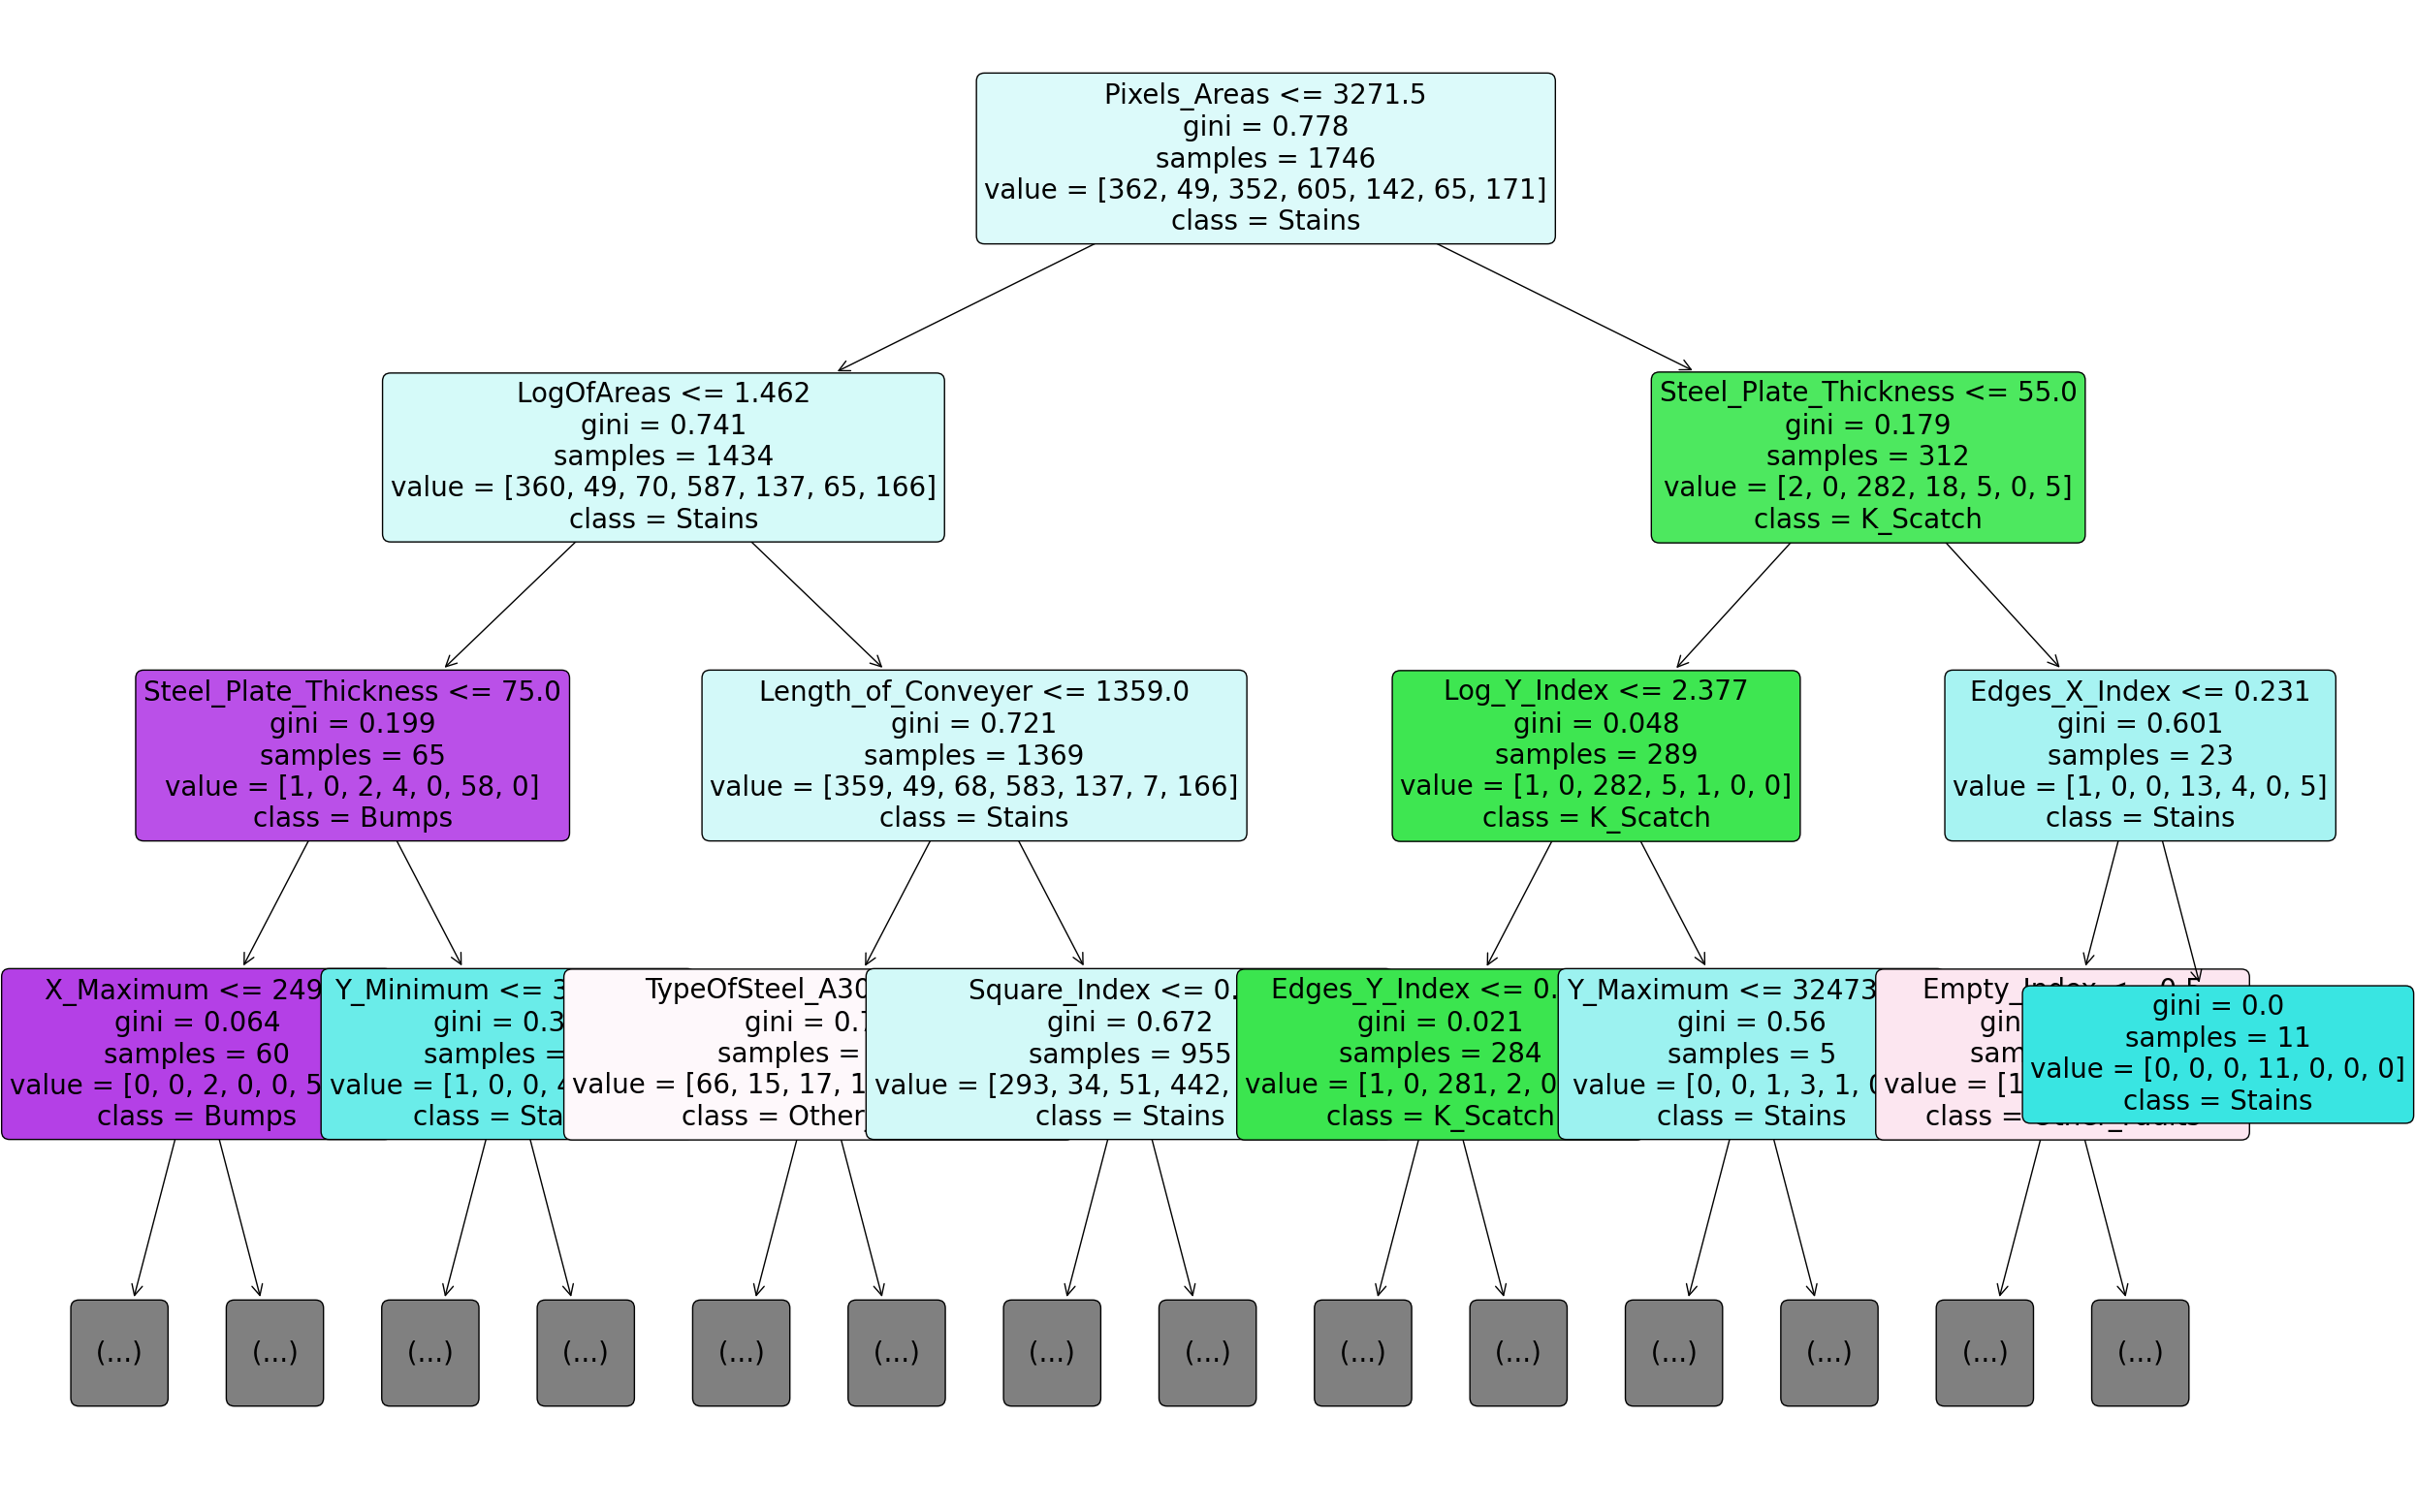

In [120]:
feature_names = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
class_names = ['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults']
fig = plt.figure(figsize=(30,20))
tree.plot_tree(dtc, max_depth=3, feature_names=feature_names, class_names=class_names, fontsize=20, filled = True, rounded = True)
fig.savefig('dtc.png')

In [121]:
y_pred = dtc.predict(X_test)

# 计算正确率、精度、召回率、F1值
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       Bumps       0.45      0.47      0.46        38
   Dirtiness       0.83      0.56      0.67         9
   K_Scratch       0.95      0.97      0.96        38
Other_Faults       0.60      0.59      0.59        70
      Pastry       0.50      0.47      0.48        17
      Stains       1.00      1.00      1.00         7
   Z_Scratch       0.68      0.81      0.74        16

    accuracy                           0.66       195
   macro avg       0.72      0.70      0.70       195
weighted avg       0.66      0.66      0.66       195



In [10]:
# 分层划分训练集和测试集，使训练集、测试集中各类别样本数量比例与原始数据集保持一致
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=3, stratify=Y)
# test_size:  若为小数，则为测试集样本占总样本的比例；若为整数，则为测试集样本数量
# random_state：随机数的种子，在需要重复试验的时候，指定一个固定值，则得到相同的划分结果
# stratify：划分前是否打乱原始样本顺序
y_train.value_counts()  # 训练集中各类样本数量统计

category
7           605
6           362
3           352
2           171
1           142
4            65
5            49
dtype: int64

In [11]:
y_test.value_counts()  # 测试集中各类样本数量统计

category
7           68
6           40
3           39
2           19
1           16
4            7
5            6
dtype: int64

In [12]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion="gini", splitter="best")
# criterion: 指定节点不纯度的度量指标，可为gini（基尼不纯度，默认）或entropy（信息增益）
# splitter：指定节点拆分策略，可为best（最佳拆分策略）或random（最佳随机拆分策略）
# max_depth：树的最大深度，默认为None，表示构造决策树，直至所有叶子都是纯净的或者包含小于min_samples_split个样本
# min_sample_split：拆分内部节点所需的最少样本量，若设置为int型数值，则为最少样本数，若设置为float型数值，则为一个比例值，
#                   最少样本数为ceil(min_samples_split * n_samples)，默认值为2
# min_samples_leaf：叶节点处所需的最小样本数，任何特征分裂点仅在其左分支和右分支中每个分支上至少留有min_samples_leaf个训练样本时，才纳入考虑，
#                   默认值为1
# ccp_alpha：用于最小代价复杂度剪枝的复杂度控制参数，取值为非负实数，默认值为0，不执行剪枝。

# 拟合模型
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

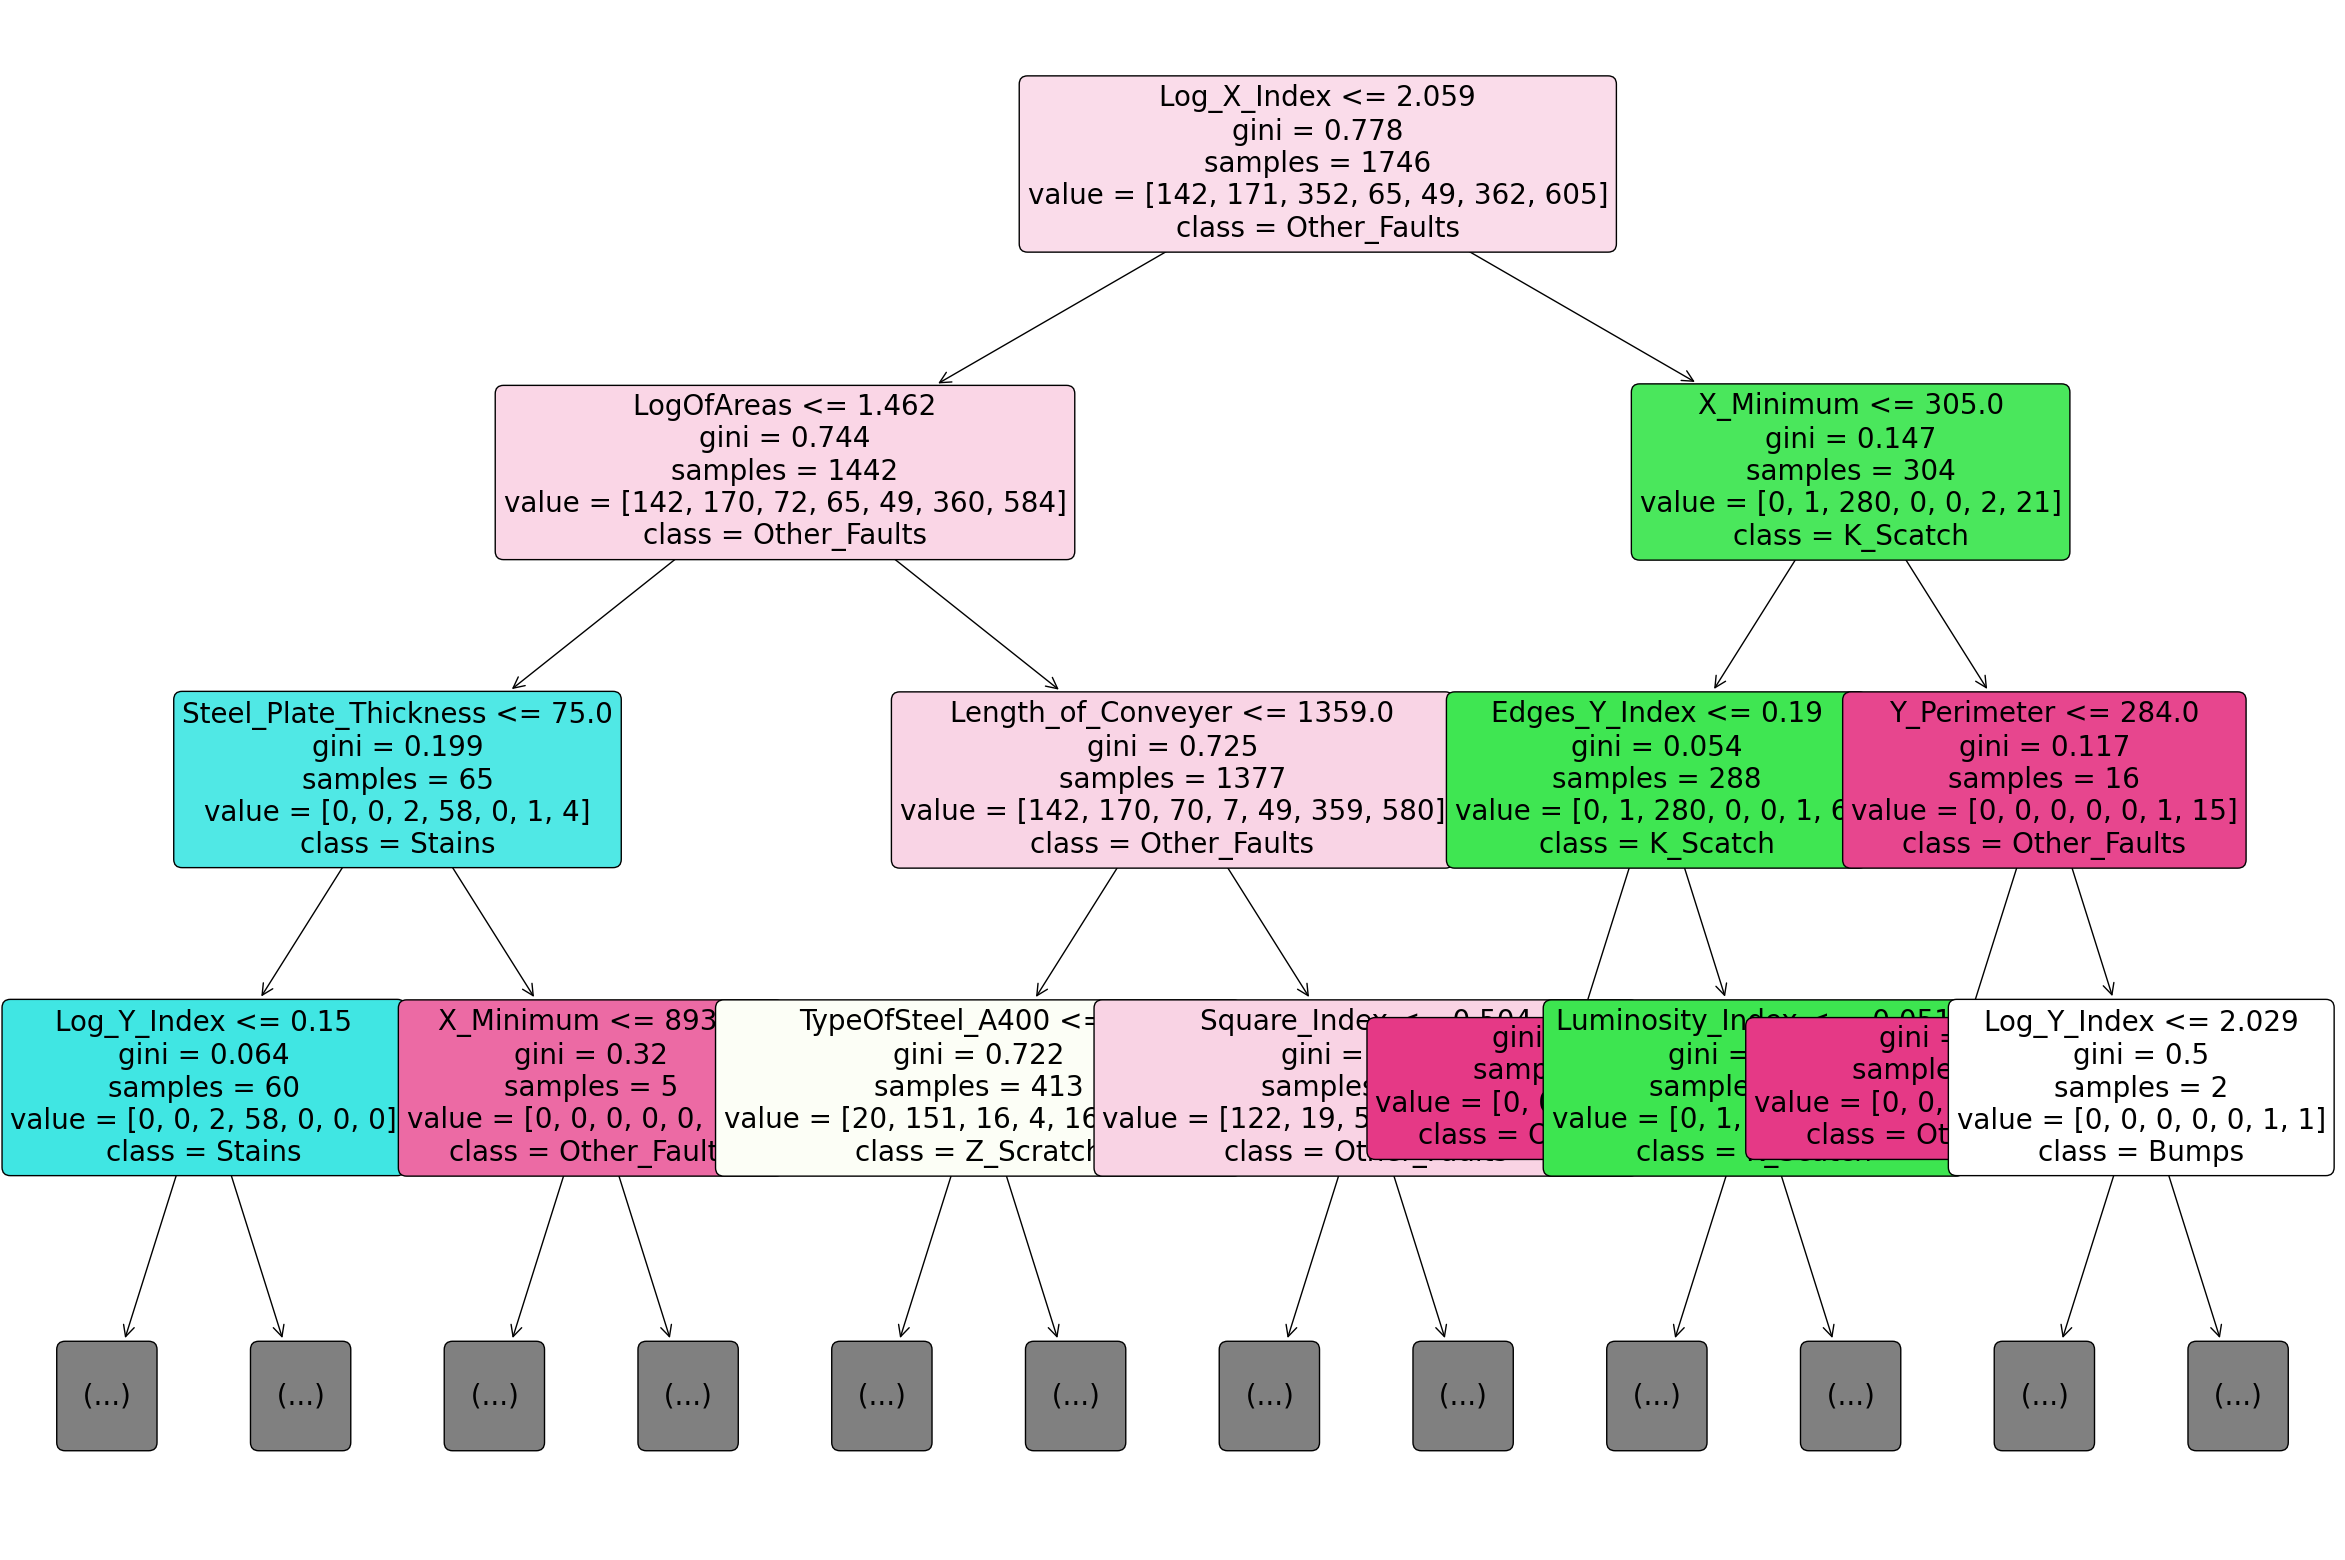

In [18]:
import matplotlib.pyplot as plt
from sklearn import tree

feature_names = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
class_names = ['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults']
fig = plt.figure(figsize=(30,20))
tree.plot_tree(dtc, max_depth=3, feature_names=feature_names, class_names=class_names, fontsize=20, filled = True, rounded = True)
fig.savefig('dtc.png')


In [19]:
y_pred = dtc.predict(X_test)

# 计算正确率、精度、召回率、F1值
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.44      0.54      0.48        13
           2       0.89      0.74      0.81        23
           3       0.95      0.93      0.94        40
           4       1.00      0.88      0.93         8
           5       0.33      0.67      0.44         3
           6       0.60      0.65      0.62        37
           7       0.74      0.70      0.72        71

    accuracy                           0.74       195
   macro avg       0.71      0.73      0.71       195
weighted avg       0.76      0.74      0.75       195

